In [23]:
import os
import networkx as nx
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import *
from functions import draw_graph
import directories as dir

In [24]:
fname = os.path.join(dir.data_dir, "projected_graph_with_integer_labels.edgelist")
g = nx.read_weighted_edgelist(fname, nodetype=str)
G = StellarGraph.from_networkx(g)

In [25]:
fname = os.path.join(dir.data_dir, "ground_truth_clusters_pickle")
with open(fname, 'rb') as fp:
    clusters = pickle.load(fp)

ground_truth_label = {}

for i, cluster in enumerate(clusters):
    for v in cluster:
        ground_truth_label[v] = i

ground_truth_labels = []
for node in range(234):
    ground_truth_labels.append(ground_truth_label[node])

In [26]:
rw = BiasedRandomWalk(G)

In [27]:
p = [0.25, 0.5, 1, 2, 4]
q = [0.25, 0.5, 1, 2, 4]
dimensions = [4, 8, 16, 32, 64, 128]

In [28]:
eval_df = pd.DataFrame(
    index=pd.MultiIndex.from_product([p, q], names=['p', 'q']),
    columns=dimensions
)

In [29]:
for u in p:
    for v in q:
        for dim in dimensions:
            weighted_walks = rw.run(
                nodes=G.nodes(),  # root nodes
                length=100,  # maximum length of a random walk
                n=30,  # number of random walks per root node
                p=u,  # Defines (unormalised) probability, 1/p, of returning to source node
                q=v,  # Defines (unormalised) probability, 1/q, for moving away from source node
                weighted=True,  # for weighted random walks
                seed=1
            )
            
            weighted_model = Word2Vec(weighted_walks, vector_size=dim, window=5, min_count=0, sg=1, workers=2, seed=1)
            
            df = (
                pd.DataFrame(
                    [weighted_model.wv[str(n)] for n in range(234)],
                    index = [i for i in range(234)]
                )
            )
            
            embeddings = df.values
            
            km = KMeans(n_clusters=4, n_init=10)
            km.fit(embeddings)
            labels_pred = km.labels_
            
            mi = mutual_info_score(labels_pred, ground_truth_labels)
            
            eval_df.loc[(u, v), dim] = mi

In [30]:
eval_df

4         8         16        32        64        128
p    q                                                               
0.25 0.25  0.960854  0.960854  0.960854  0.960854  0.960854  0.960854
     0.50  0.970139  0.970139  0.973708  0.981479  0.981479  0.973708
     1.00  0.970139  0.970139  0.970139  0.970139  0.970139  0.970139
     2.00  0.962562  0.973708  0.973708  0.973708  0.962562  0.953463
     4.00  0.923897  0.953463  0.953463  0.953463  0.948734  0.939635
0.50 0.25  0.897451  0.937692  0.937692  0.840499  0.840499  0.827717
     0.50  0.882989  0.962562  0.962562  0.962562  0.962562  0.962562
     1.00   0.99468  0.981479  0.981479  0.835044  0.981479  0.981479
     2.00  0.855212  0.962562  0.962562  0.953463  0.952848  0.952848
     4.00  0.977061  0.962562  0.973708  0.970139  0.970139  0.973708
1.00 0.25  0.804147  0.943715  0.962562  0.962562  0.973708  0.962562
     0.50  0.956305  0.948833  0.948833  0.869376  0.962562  0.953463
     1.00  0.962562  0.962562  0.973708  0.840291  0.973708  0.962562
     2.00  0.897181  0.962562  0.973708   0.95988   0.95988  0.830094
     4.00  0.851632  0.953463  0.978035  0.962562  0.952848  0.938988
2.00 0.25  0.808699  0.945302  0.945302  0.945302  0.945302  0.945302
     0.50  0.740238  0.953463  0.953463  0.953463  0.947342  0.953463
     1.00  0.839372  0.973708  0.953463  0.962562  0.948734  0.948734
     2.00   0.81822  0.943715  0.962562  0.954657  0.901702  0.946994
     4.00  0.970029  0.962562  0.928598  0.962483  0.928598  0.953203
4.00 0.25  0.747002  0.937692  0.928598  0.692894  0.790215  0.928598
     0.50  0.842199  0.962562  0.859726  0.815708  0.973708  0.973708
     1.00  0.827908  0.946718  0.928598  0.825771  0.929856  0.923897
     2.00  0.879733  0.973708  0.844261  0.794808  0.788022   0.67492
     4.00  0.843339  0.985216  0.985216   0.99468  0.792538  0.792538

In [32]:
eval_df = eval_df.astype(float)
best_combination = eval_df.stack().idxmax()
print(best_combination)

best_p = best_combination[0]
best_q = best_combination[1]
best_dim = best_combination[2]

eval_df.loc[(best_p, best_q), best_dim]

(0.5, 1.0, 4)


0.9946795117028348

## Compare kmeans with 4 and 5 clusters

In [33]:
weighted_walks = rw.run(
    nodes=G.nodes(),  # root nodes
    length=100,  # maximum length of a random walk
    n=30,  # number of random walks per root node
    p=best_p,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=best_q,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=1
)

weighted_model = Word2Vec(weighted_walks, vector_size=best_dim, window=5, min_count=0, sg=1, workers=2, seed=1)

In [34]:
df = (
    pd.DataFrame(
        [weighted_model.wv[str(n)] for n in range(234)],
        index = [i for i in range(234)]
    )
)
embeddings = df.values

### k=4

In [37]:
km = KMeans(n_clusters=4, n_init=10)
km.fit(embeddings)
labels_pred_4_clusters = km.labels_

In [46]:
nmi = normalized_mutual_info_score(labels_pred_4_clusters, ground_truth_labels)
rand = rand_score(labels_pred_4_clusters, ground_truth_labels)

eval_df_4_clusters = pd.DataFrame([[4, nmi, rand]], 
                columns=['Clusters', 'NMI', 'Rand'])
eval_df_4_clusters

,Clusters,NMI,Rand
0,4,0.91967,0.980742


### k=5

In [48]:
km = KMeans(n_clusters=5, n_init=10)
km.fit(embeddings)
labels_pred_5_clusters = km.labels_

In [49]:
nmi = normalized_mutual_info_score(labels_pred_5_clusters, ground_truth_labels)
rand = rand_score(labels_pred_5_clusters, ground_truth_labels)

eval_df_5_clusters = pd.DataFrame([[5, nmi, rand]], 
                columns=['Clusters', 'NMI', 'Rand'])
eval_df_5_clusters


,Clusters,NMI,Rand
0,5,0.855825,0.951653


### Metrics Comparison

In [50]:
df = pd.concat([eval_df_4_clusters, eval_df_5_clusters])

a = df.loc[df.Clusters == 4, ['NMI', 'Rand']].values.flatten().tolist()
b = df.loc[df.Clusters == 5, ['NMI', 'Rand']].values.flatten().tolist()

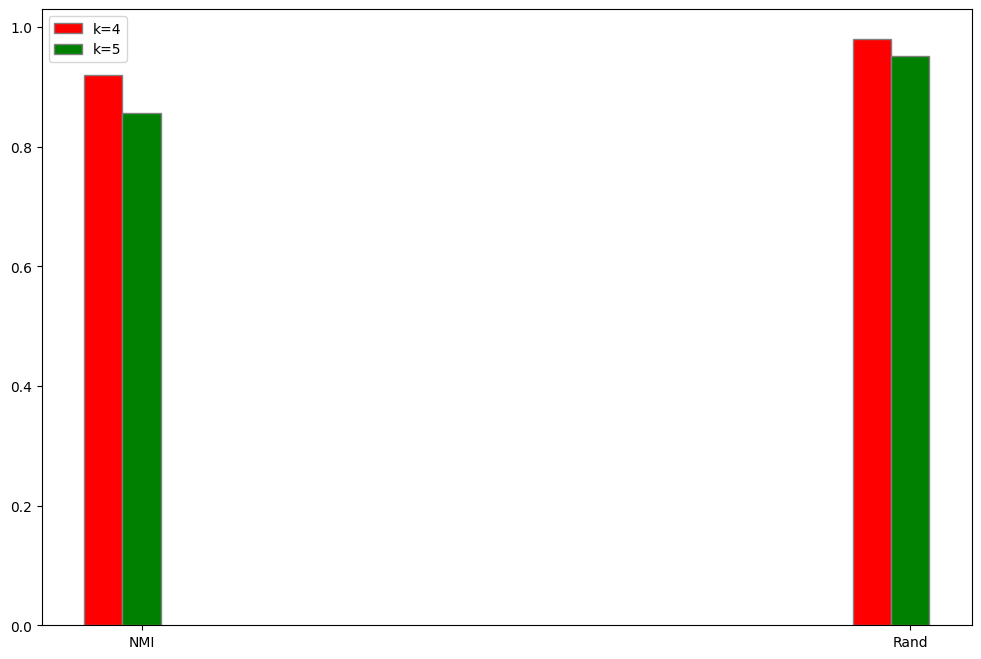

In [53]:
barWidth = 0.05
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(a))
br2 = [x + barWidth for x in br1]

plt.bar(br1, a, color ='r', width = barWidth,
        edgecolor ='grey', label ='k=4')
plt.bar(br2, b, color ='g', width = barWidth,
        edgecolor ='grey', label ='k=5')

plt.xticks([r + barWidth for r in range(len(a))],
        ['NMI', 'Rand'])

plt.legend()

### Graph Visualisation

In [54]:
party_length = {}
for i in range(4):
  count = 0
  for val in labels_pred_4_clusters:
      if val == i:
          count += 1
  party_length[i] = count
party_length

{0: 131, 1: 70, 2: 9, 3: 24}

In [55]:
colors = {}

for k, v in party_length.items():
    if v == 9:
        colors[k] = 'k'
    elif v == 24:
        colors[k] = 'g'
    elif v == 70:
        colors[k] = 'r'
    else:
        colors[k] = 'b'

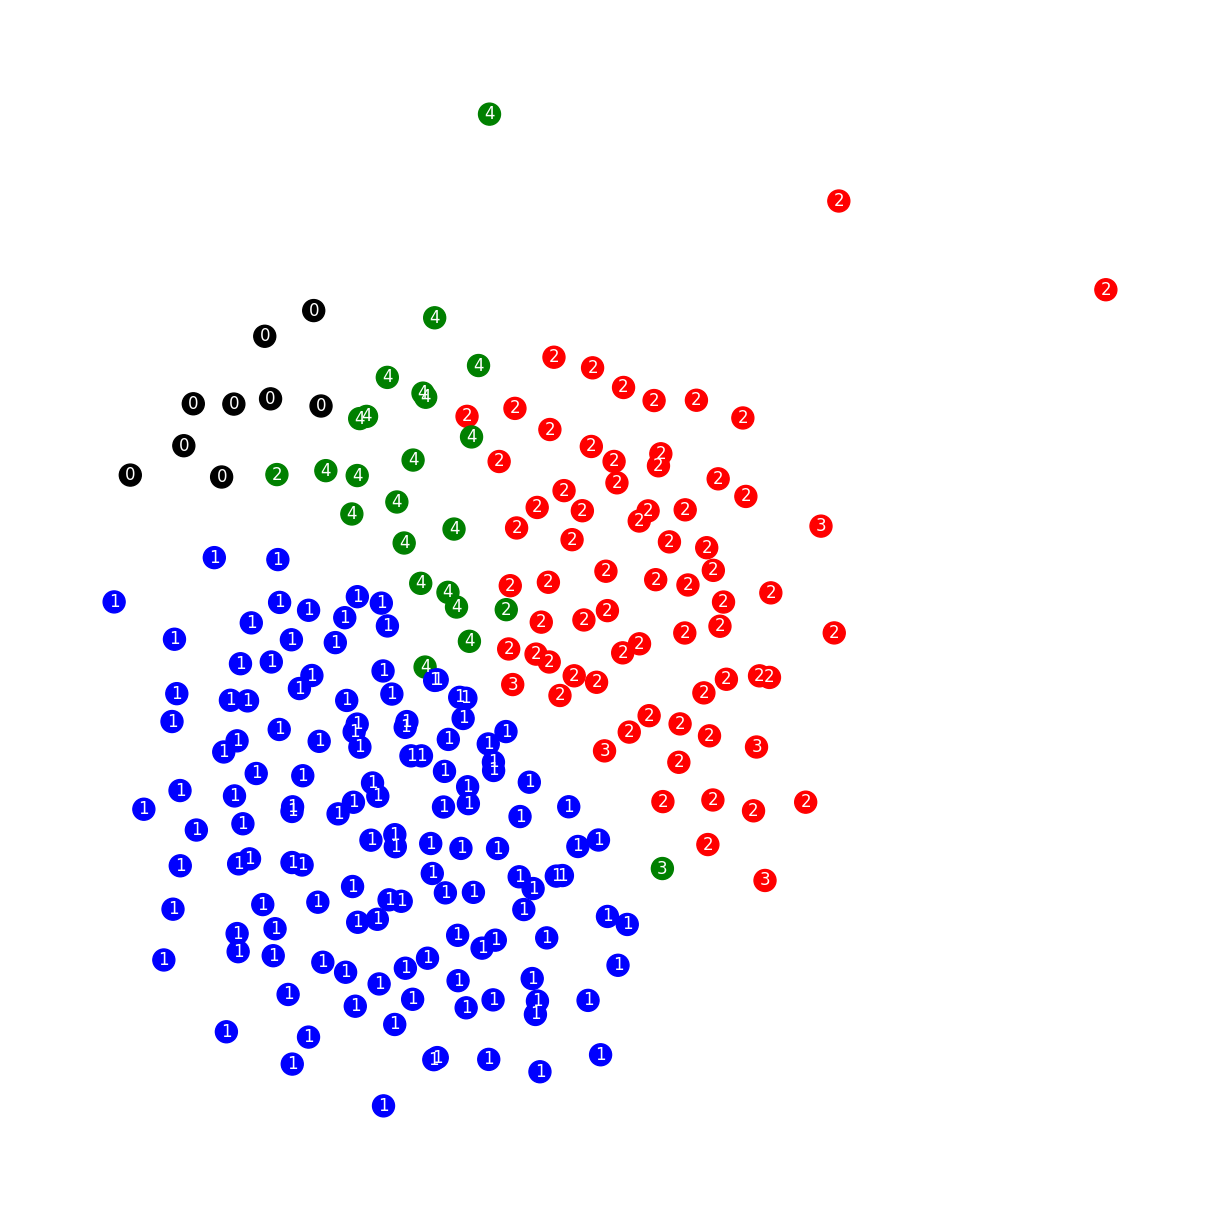

In [56]:
labels = {n: ground_truth_label[int(n)] for n in G.nodes()}
color_map = [colors[labels_pred_4_clusters[int(n)]] for n in G.nodes()]
draw_graph(g, labels, color_map)